In [146]:
# Data EDA and plotting

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint, uniform
%matplotlib inline

# Models

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostClassifier

# Model Evaluation

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import PolynomialFeatures


In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## Convert categorical dtypes to int

In [8]:
df['person_home_ownership'] = df['person_home_ownership'].astype('category')
df['person_home_ownership'] = df['person_home_ownership'].cat.codes

df['loan_intent'] = df['loan_intent'].astype('category')
df['loan_intent'] = df['loan_intent'].cat.codes

df['loan_grade'] = df['loan_grade'].astype('category')
df['loan_grade'] = df['loan_grade'].cat.codes

df['cb_person_default_on_file'] = df['cb_person_default_on_file'].astype('category')
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].cat.codes

# Same for test set
df_test['person_home_ownership'] = df_test['person_home_ownership'].astype('category')
df_test['person_home_ownership'] = df_test['person_home_ownership'].cat.codes

df_test['loan_intent'] = df_test['loan_intent'].astype('category')
df_test['loan_intent'] = df_test['loan_intent'].cat.codes

df_test['loan_grade'] = df_test['loan_grade'].astype('category')
df_test['loan_grade'] = df_test['loan_grade'].cat.codes

df_test['cb_person_default_on_file'] = df_test['cb_person_default_on_file'].astype('category')
df_test['cb_person_default_on_file'] = df_test['cb_person_default_on_file'].cat.codes


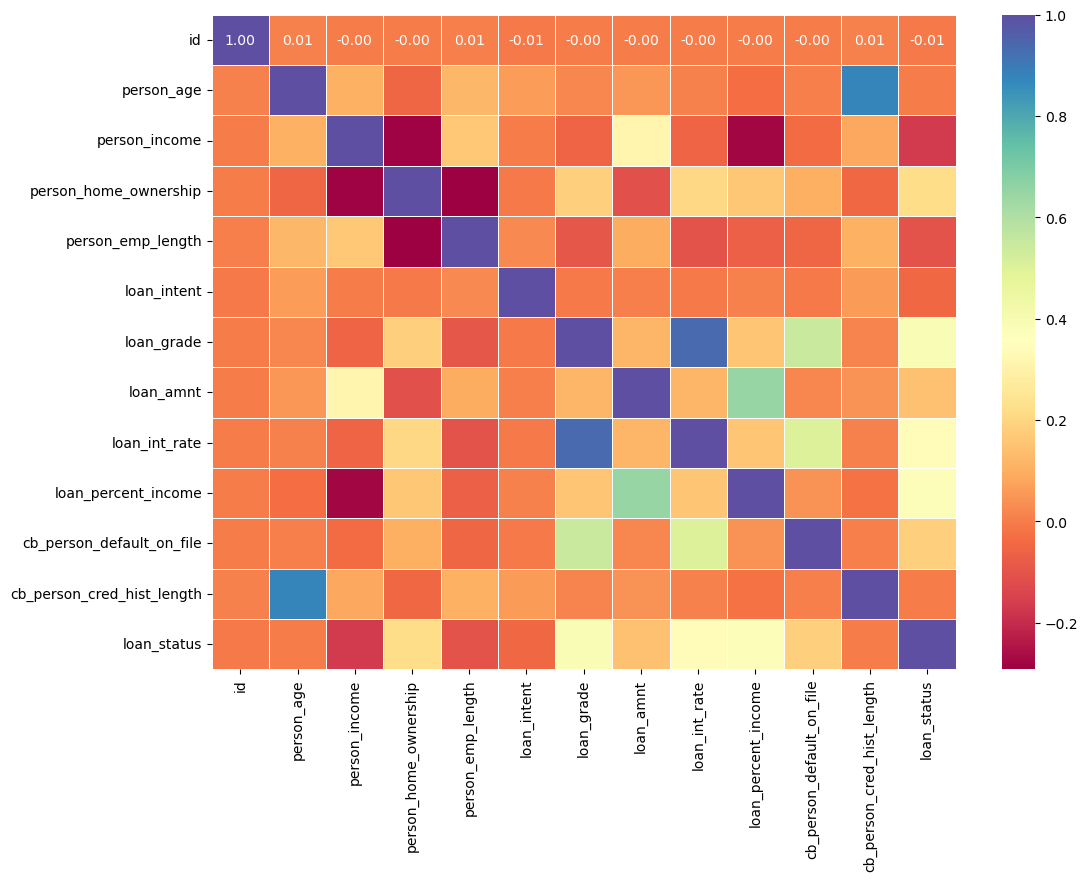

In [10]:
#df = df.drop('id', axis=1)
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (12, 8.5))
ax = sns.heatmap(corr_matrix, annot = True, linewidths = 0.5, fmt = ".2f", cmap = "Spectral")

In [44]:
# Grid Search for best params:
np.random.seed(42)

# Gridsearch here was found to be too heavy a lift for my local machine so optimal params 
# were obtained via gridsearchcv in a google colab notebook

catboost_param_dist = {
    'depth': np.arange(4, 10, 2),
    'learning_rate': np.arange(0.01, 0.3, .05),
    'iterations': np.arange(10, 1000, 100),
    'l2_leaf_reg': np.arange(1, 10, 2),
    'border_count': np.arange(1, 255, 50),
    'bagging_temperature': np.arange(0.0, 1.0, 0.2),
    'random_strength': np.arange(0.0, 1.0, 0.2)
}

grid_search_cb = GridSearchCV(
    estimator=CBmodel,
    param_grid=catboost_param_dist,
    cv=5,
    verbose=2
)

# Best params found via Google Colab
cat_features = ['person_age','person_income', 'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
CBmodel=CatBoostClassifier(cat_features=cat_features,
                        bagging_temperature=0.0,
                        border_count=128,
                        depth=4,
                        iterations=1000,
                        l2_leaf_reg=1,
                        learning_rate=0.03,
                        random_strength=0.7)
X = df.drop(['loan_status', 'id'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# X_train = df.drop(['loan_status', 'id'], axis=1)
# y_train = df['loan_status']
# X_test = df_test.drop(['id'], axis=1)
# y_test = df_test['loan_status']

## Initial Catboost fitting

In [45]:
np.random.seed(42)

CBmodel.fit(X_train, y_train)
CBmodel.score(X_test, y_test)

0:	learn: 0.6537549	total: 10.4ms	remaining: 10.4s
1:	learn: 0.6173054	total: 21ms	remaining: 10.5s
2:	learn: 0.5838445	total: 28.1ms	remaining: 9.32s
3:	learn: 0.5539850	total: 36.1ms	remaining: 9s
4:	learn: 0.5259577	total: 43.5ms	remaining: 8.65s
5:	learn: 0.5001684	total: 52.7ms	remaining: 8.73s
6:	learn: 0.4764848	total: 60.5ms	remaining: 8.58s
7:	learn: 0.4546367	total: 68.2ms	remaining: 8.46s
8:	learn: 0.4346746	total: 76.3ms	remaining: 8.4s
9:	learn: 0.4165116	total: 85.3ms	remaining: 8.45s
10:	learn: 0.3999171	total: 93.9ms	remaining: 8.44s
11:	learn: 0.3846459	total: 101ms	remaining: 8.31s
12:	learn: 0.3704617	total: 108ms	remaining: 8.2s
13:	learn: 0.3579961	total: 115ms	remaining: 8.12s
14:	learn: 0.3460531	total: 123ms	remaining: 8.08s
15:	learn: 0.3352478	total: 130ms	remaining: 8.02s
16:	learn: 0.3256090	total: 139ms	remaining: 8.01s
17:	learn: 0.3164908	total: 147ms	remaining: 8.04s
18:	learn: 0.3080930	total: 155ms	remaining: 8.01s
19:	learn: 0.3003533	total: 163ms	rem

0.9531929405746441

# Polynomial Feature Engineering

### Spoiler* did not improve results, but worth exploring in further analysis

In [14]:
df_mod = df.copy()
df_mod = df_mod.drop('id', axis=1)

# Combining features with low impact into composite feature
# Note - this did not improve the overall result initially, but did infom future decisions to split the feature set upon which to run first layer models 

df_mod['loan_composite'] = df_mod['loan_int_rate'] * df_mod['loan_amnt']
df_mod['loan_composite'] = (df_mod['loan_composite']**0.5).astype(int)


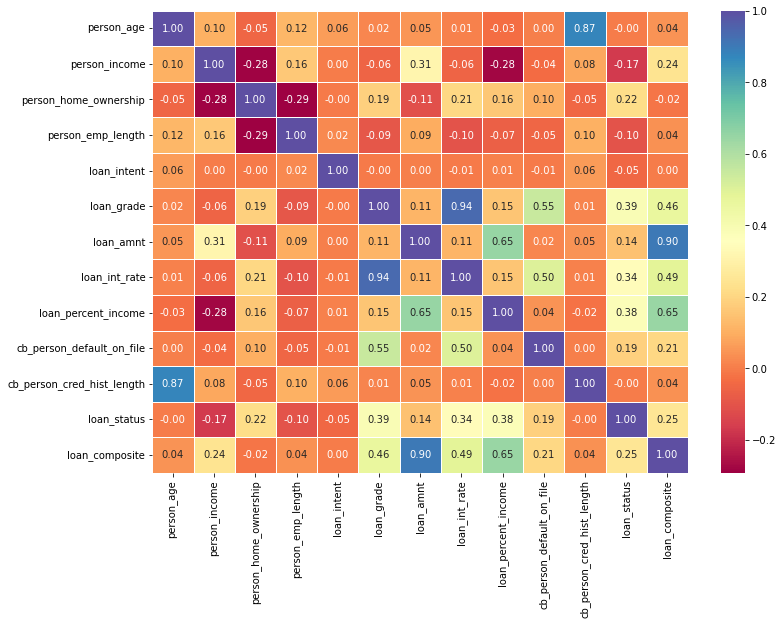

In [22]:
corr_matrix = df_mod.corr()
fig, ax = plt.subplots(figsize = (12, 8.5))
ax = sns.heatmap(corr_matrix, annot = True, linewidths = 0.5, fmt = ".2f", cmap = "Spectral")

## Adding polynomial features with Sklearn's PolynomialFeatures class
### *Spoiler: did not yield measurably better results, but we do it for fun anyway

In [101]:
np.random.seed(42)

cat_features = ['person_age','person_income', 'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
model=CatBoostClassifier(
                        bagging_temperature=0.0,
                        border_count=128,
                        depth=4,
                        iterations=1000,
                        l2_leaf_reg=1,
                        learning_rate=0.03,
                        random_strength=0.7)

X = df_mod.drop(['loan_status'],  axis=1)
y = df_mod['loan_status']


In [102]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_poly.shape

(58645, 91)

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2)

np.random.seed(42)

model.fit(X_train, y_train)
model.score(X_test, y_test)

0:	learn: 0.6550307	total: 5.71ms	remaining: 5.7s
1:	learn: 0.6201716	total: 10.3ms	remaining: 5.12s
2:	learn: 0.5878395	total: 14.7ms	remaining: 4.9s
3:	learn: 0.5573905	total: 19.5ms	remaining: 4.86s
4:	learn: 0.5319429	total: 25.2ms	remaining: 5.02s
5:	learn: 0.5062555	total: 35.2ms	remaining: 5.83s
6:	learn: 0.4824118	total: 47.5ms	remaining: 6.73s
7:	learn: 0.4614128	total: 52.8ms	remaining: 6.55s
8:	learn: 0.4417131	total: 58.3ms	remaining: 6.42s
9:	learn: 0.4249696	total: 64.1ms	remaining: 6.34s
10:	learn: 0.4089609	total: 69.8ms	remaining: 6.27s
11:	learn: 0.3938505	total: 74.7ms	remaining: 6.15s
12:	learn: 0.3792745	total: 79.2ms	remaining: 6.01s
13:	learn: 0.3656910	total: 84ms	remaining: 5.92s
14:	learn: 0.3542992	total: 88.6ms	remaining: 5.82s
15:	learn: 0.3438534	total: 93.3ms	remaining: 5.74s
16:	learn: 0.3337354	total: 98.1ms	remaining: 5.67s
17:	learn: 0.3242952	total: 103ms	remaining: 5.61s
18:	learn: 0.3154037	total: 108ms	remaining: 5.55s
19:	learn: 0.3074222	total: 

0.9526813880126183

# Combining 3 boosted gradient algorithms (Catboost x Lightboost x XGBoost) in an ensemble
## 1) Train each model on a sequestered subset of training data
## 2) Add predicted probabilities for each model as an additional feature in the dataset
## 3) Train a final Catboost (due to slightly higher overall accuracy) on the modified dataset

In [ ]:
#Only run this cell if running again after df has been modified
X = df.drop(['lightboost_proba_pos', 'XGBoost_proba', 'loan_status', 'id'], axis=1)

In [22]:
MODEL_SPLIT = 30000
X = df.drop(['loan_status', 'id'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X_train[:MODEL_SPLIT]
y_train = y_train[:MODEL_SPLIT]

np.random.seed(42)

# Parameters for initial ensemble models, obtained in a Google colab notebook via Optuna hyperparameter studies

# KGBOOST
XGparams = {'learning_rate': 0.00655705964501654, 
'max_depth': 9, 
'subsample': 0.6192103134365866, 
'colsample_bytree': 0.8922617376689524, 
'min_child_weight': 18}

# LIGHTBOOST
LGBMparams = {'n_estimators': 10000, 
'learning_rate': 0.29877317070756954, 
'num_leaves': 200, 
'max_depth': 3, 
'min_data_in_leaf': 3200, 
'lambda_l1': 0, 
'lambda_l2': 0, 
'min_gain_to_split': 0.13577620443960492, 
'bagging_fraction': 0.7, 
'bagging_freq': 1, 
'feature_fraction': 0.9}

# CATBOOST
CBparams = {
    'bagging_temperature': 0.0,
    'border_count': 128,
    'depth':4,
    'iterations':1000,
    'l2_leaf_reg':1,
    'learning_rate':0.03,
    'random_strength':0.7
}

XGBmodel=XGBClassifier()
XGBmodel.fit(X_train, y_train)
print(f"XGBoost Model Accuracy Score: {XGBmodel.score(X_test, y_test)}")

LBmodel=LGBMClassifier()
LBmodel.fit(X_train, y_train)
print(f"LightGBM Model Accuracy Score: {LBmodel.score(X_test, y_test)}")

CBmodel=CatboostClassifier()
CBmodel.fit(X_train, y_train)
print(f"Catboost Model Accuracy Score: {CBmodel.score(X_test, y_test)}")


XGBoost Model Accuracy Score: 0.9520845766902549
[LightGBM] [Info] Number of positive: 4288, number of negative: 25712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142933 -> initscore=-1.791137
[LightGBM] [Info] Start training from score -1.791137
LightGBM Model Accuracy Score: 0.9531076818143064


In [24]:
Lightboost_proba = LBmodel.predict_proba(X)
LGB_proba = []
for column in Lightboost_proba:
    LGB_proba.append(column[0])

# Same for test
Lightboost_proba_test = LBmodel.predict_proba(X_test)
LGB_proba_test = []
for column in Lightboost_proba_test:
    LGB_proba_test.append(column[0])

XGBoost_proba = XGBmodel.predict_proba(X)
XGB_proba = []
for column in XGBoost_proba:
    XGB_proba.append(column[0])

# Same for test
XGBoost_proba_test = XGBmodel.predict_proba(X_test)
XGB_proba_test = []
for column in XGBoost_proba_test:
    XGB_proba_test.append(column[0])

df['lightboost_proba_pos'] = LGB_proba
df['XGBoost_proba'] = XGB_proba

In [30]:
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,lightboost_proba_pos,XGBoost_proba
0,0,37,35000,3,0.0,1,1,6000,11.49,0.17,0,14,0,0.965178,0.980226
1,1,22,56000,2,6.0,3,2,4000,13.35,0.07,0,2,0,0.979593,0.991312
2,2,29,28800,2,8.0,4,0,6000,8.90,0.21,0,10,0,0.979757,0.989894
3,3,30,70000,3,14.0,5,1,12000,11.11,0.17,0,5,0,0.993910,0.997423
4,4,22,60000,3,2.0,3,0,6000,6.92,0.10,0,3,0,0.992791,0.997698


In [184]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Integer
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

# Prepare the data
X = df.drop(['loan_status', 'id'], axis=1)
y = df['loan_status']

# Split data: train (60%), validation (20%), and holdout (test) (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Split data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[MODEL_SPLIT:]
y_train = y_train[MODEL_SPLIT:]

# Define a function to optimize based on test data performance
def optimize_catboost(params):
    # Unpack the parameters
    depth = int(params[0])
    iterations = int(params[1])
    learning_rate = params[2]
    l2_leaf_reg = params[3]
    bagging_temperature = params[4]
    border_count = int(params[5])
    random_strength = params[6]

    # Create the CatBoost model with the given parameters
    model = CatBoostClassifier(cat_features=cat_features,
                               depth=depth,
                               iterations=iterations,
                               learning_rate=learning_rate,
                               l2_leaf_reg=l2_leaf_reg,
                               bagging_temperature=bagging_temperature,
                               border_count=border_count,
                               random_strength=random_strength,
                               silent=True)

    # Train on the training set
    model.fit(X_train, y_train)

    # Evaluate on the test set
    test_score = model.score(X_test, y_test)

    print("score:", test_score)
    print("params:", params)
    print()

    # Return the negative test score (since gp_minimize minimizes functions)
    return -test_score

# Define the hyperparameter space to search
param_space = [
    Integer(2, 10),          # depth
    Integer(100, 1000),      # iterations
    Real(0.01, 0.5, 'log-uniform'),  # learning_rate
    Real(0.1, 10, 'log-uniform'),    # l2_leaf_reg
    Real(0.0, 1.0),          # bagging_temperature
    Integer(16, 256),        # border_count
    Real(0.1, 1.0),          # random_strength
]

# Use gp_minimize (Gaussian Process optimization) to find the best parameters
result = gp_minimize(optimize_catboost,      # the function to minimize
                     param_space,            # the bounds on each dimension of x
                     n_calls=50,             # the number of evaluations of f
                     random_state=42)        # to make the experiment reproducible

# Output the best parameters and score
best_params = result.x
best_score = -result.fun  # Convert back to positive score
print(f"Best Parameters: {best_params}")
print(f"Test Score: {best_score}")

# Train final model with the best parameters on the entire training set
best_model = CatBoostClassifier(cat_features=cat_features,
                                depth=int(best_params[0]),
                                iterations=int(best_params[1]),
                                learning_rate=best_params[2],
                                l2_leaf_reg=best_params[3],
                                bagging_temperature=best_params[4],
                                border_count=int(best_params[5]),
                                random_strength=best_params[6],
                                silent=True)

best_model.fit(X_train, y_train)

# Evaluate final model on the test set
final_test_score = best_model.score(X_test, y_test)
print(f"Final Test Score: {final_test_score}")


score: 0.9604399352033421
params: [8, 265, 0.21118915966823948, 1.562069367563987, 0.44583275285359125, 40, 0.5133240027692806]

score: 0.9628271804927956
params: [5, 229, 0.12759686136280085, 0.129665117537604, 0.7219987722668249, 241, 0.1007008892569129]

score: 0.962059851649757
params: [10, 656, 0.10944108064793875, 0.10330768043240404, 0.02306242504141576, 142, 0.45987487454373]



KeyboardInterrupt: 

## Best Parameters: 
[2, 717, 0.010574491591219235, 9.281684625298357, 0.491492554943993, 110, 0.5029858816637588]
### Validation Score: 0.9638502856168472
### Test Score: 0.9577969136328758


## Best Parameters: 
[2, 1000, 0.01, 0.5811407217864795, 0.33093110110898305, 8, 0.2460429188677122]
### Test Score: 0.9519993179299173
### Final Test Score: 0.9519993179299173

# Next Steps to attempt to squeeze out a few decimal points of accuracy:

## Split initial dataset into different groups of features based on hypotheses below about correlation between features

## Test combinations of initial XG, LG, CB models on different feature subsets

## Choose the best and tune hyperparameters for final CB Ensemble model

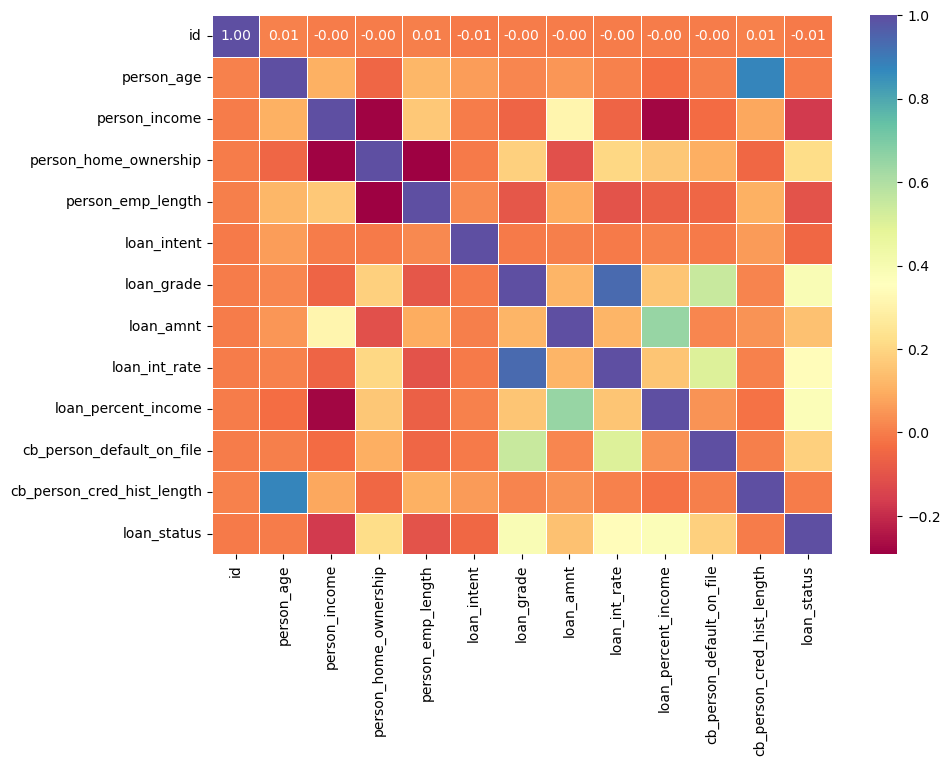

In [59]:
#df = df.drop(['lightboost_proba_pos', 'XGBoost_proba'], axis=1)
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize = (10, 7))
ax = sns.heatmap(corr_matrix, annot = True, linewidths = 0.5, fmt = ".2f", cmap = "Spectral")

## Hypothesis: 
### We separate the feature set into 1) features that are loan-centric, and 2) features that are applicant-centric.  We hypothesize that training initial models on these features might yield an additional composite feature that will be a better overall predictor of loan approval when incorporated back into the initial dataset 

### Correlations to explore:
* (lets call this "loan attributes): Loan_Grade, CB_person_default_on_file, loan_int_rate, loan_amnt
* (Lets call this "applicant stability") cb_person_cred_hist_length, person_emp_length, person_home_ownership, person_income, person_age

## Loan Attributes

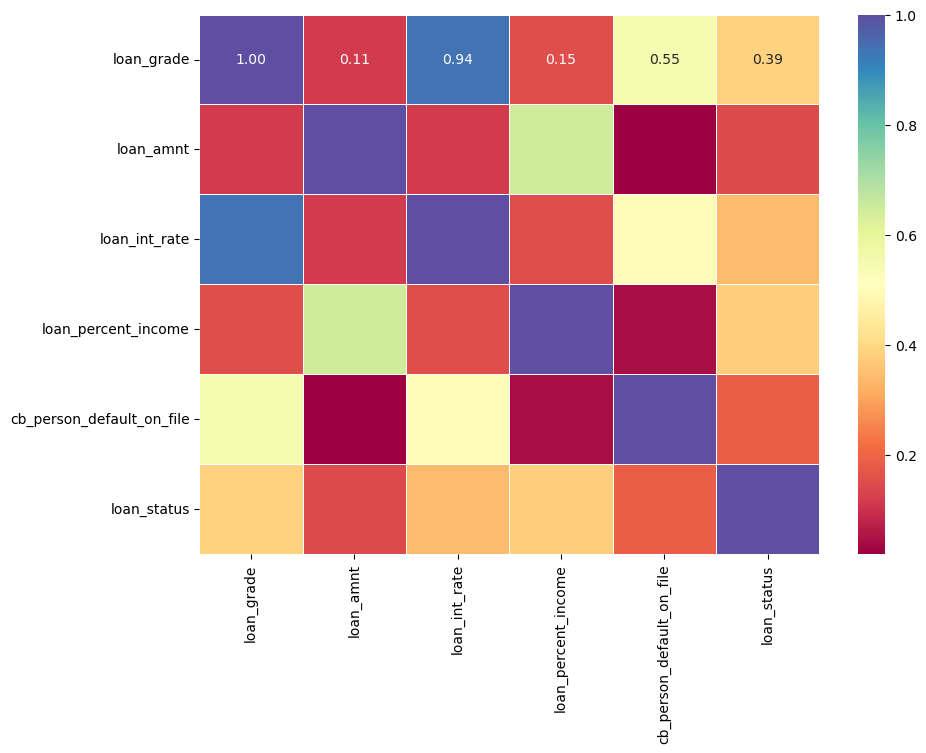

In [390]:
loan_attributes = df.drop(['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'cb_person_cred_hist_length', 'loan_intent', 'id'], axis=1)
corr_matrix = loan_attributes.corr()
fig, ax = plt.subplots(figsize = (10, 7))
ax = sns.heatmap(corr_matrix, annot = True, linewidths = 0.5, fmt = ".2f", cmap = "Spectral")

## Applicant Stability

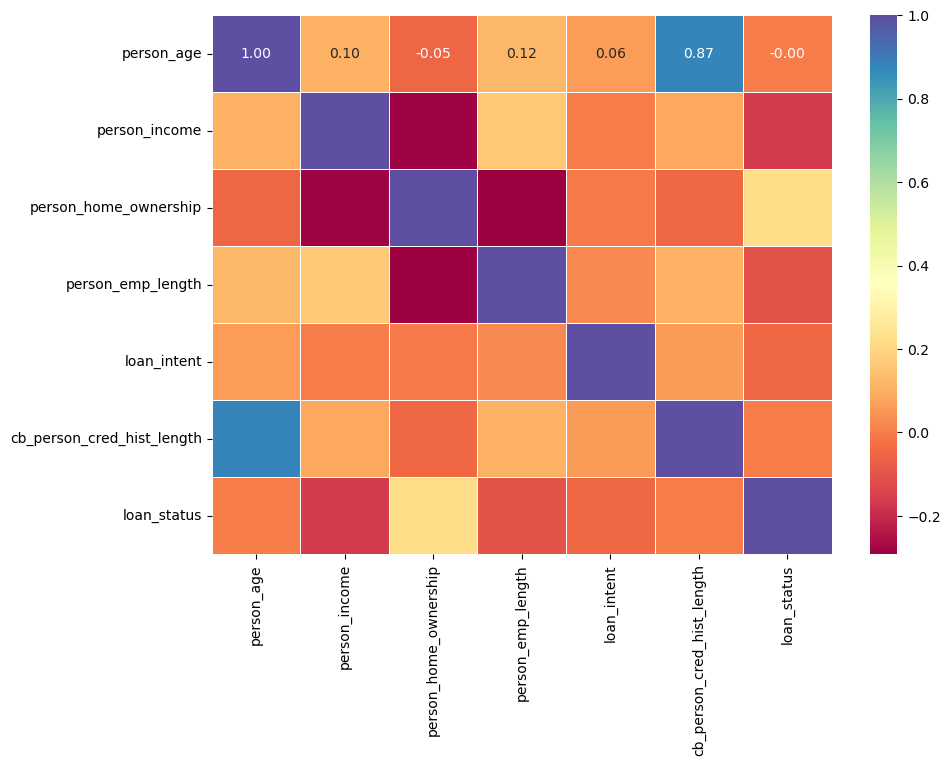

In [392]:
applicant_stability = df.drop(['loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'id'], axis=1)
corr_matrix = applicant_stability.corr()
fig, ax = plt.subplots(figsize = (10, 7))
ax = sns.heatmap(corr_matrix, annot = True, linewidths = 0.5, fmt = ".2f", cmap = "Spectral")

## Now that we've split the data into these two descrete categories, we can see that at first blush there is a degree of separation between the two.  

## Now we'll split all 58k samples down into 30k for training, saving the remainder for training a final ensemble, first with the 'applicant stability' dataset, and next with the 'loan attributes' dataset 

In [396]:
# Applicant Stability portion of the dataset

MODEL_SPLIT = 30000
X = applicant_stability.drop(['loan_status'], axis=1)
y = applicant_stability['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X_train[:MODEL_SPLIT]
y_train = y_train[:MODEL_SPLIT]

np.random.seed(42)

XGBmodel=XGBClassifier()
XGBmodel.fit(X_train, y_train)
print(f"XGBoost Model Accuracy Score: {XGBmodel.score(X_test, y_test)}")

LBmodel=LGBMClassifier()
LBmodel.fit(X_train, y_train)
print(f"LightGBM Model Accuracy Score: {LBmodel.score(X_test, y_test)}")

CBmodel=CatBoostClassifier()
CBmodel.fit(X_train, y_train)
print(f"Catboost Model Accuracy Score: {CBmodel.score(X_test, y_test)}")


XGBoost Model Accuracy Score: 0.8744138460226788
[LightGBM] [Info] Number of positive: 4288, number of negative: 25712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142933 -> initscore=-1.791137
[LightGBM] [Info] Start training from score -1.791137
LightGBM Model Accuracy Score: 0.8779094551965214
Learning rate set to 0.044021
0:	learn: 0.6586359	total: 4.04ms	remaining: 4.03s
1:	learn: 0.6258849	total: 7.52ms	remaining: 3.75s
2:	learn: 0.5971348	total: 11.4ms	remaining: 3.77s
3:	learn: 0.5719143	total: 15.2ms	remaining: 3.79s
4:	learn: 0.5491735	total: 18.7ms	remaining: 3.73s
5:	learn: 0.5297143	total: 22ms	remaining: 3.65s
6:	learn: 0.

## Initial accuracy scores:
* LightGBM Model Accuracy Score: 0.8779094551965214
* XGBoost Model Accuracy Score: 0.8744138460226788
* Catboost Model Accuracy Score: 0.8778241964361838

## Applying applicant stability feature to entire dataset length

In [425]:
np.random.seed(42)
X = applicant_stability.drop(['loan_status'], axis=1)
y = applicant_stability['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [427]:
LGBM_applicant_proba = LBmodel.predict_proba(X)
LGBM_app_proba = []
for column in LGBM_applicant_proba:
    LGBM_app_proba.append(column[0])


In [464]:
X['LGBM_app_proba']  = LGBM_app_proba


## Loan Attribute portion of the dataset

In [431]:
MODEL_SPLIT = 30000
X = loan_attributes.drop(['loan_status'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train = X_train[:MODEL_SPLIT]
y_train = y_train[:MODEL_SPLIT]

np.random.seed(42)

XGBmodel=XGBClassifier()
XGBmodel.fit(X_train, y_train)
print(f"XGBoost Model Accuracy Score: {XGBmodel.score(X_test, y_test)}")

LBmodel=LGBMClassifier()
LBmodel.fit(X_train, y_train)
print(f"LightGBM Model Accuracy Score: {LBmodel.score(X_test, y_test)}")

CBmodel=CatBoostClassifier()
CBmodel.fit(X_train, y_train)
print(f"Catboost Model Accuracy Score: {CBmodel.score(X_test, y_test)}")


XGBoost Model Accuracy Score: 0.9042544121408475
[LightGBM] [Info] Number of positive: 4266, number of negative: 25734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142200 -> initscore=-1.797136
[LightGBM] [Info] Start training from score -1.797136
LightGBM Model Accuracy Score: 0.9072384687526643
Learning rate set to 0.044021
0:	learn: 0.6421326	total: 8.08ms	remaining: 8.07s
1:	learn: 0.5972266	total: 12.9ms	remaining: 6.44s
2:	learn: 0.5577338	total: 17.1ms	remaining: 5.68s
3:	learn: 0.5216702	total: 20.9ms	remaining: 5.2s
4:	learn: 0.4900309	total: 25.8ms	remaining: 5.14s
5:	learn: 0.4614533	total: 33.9ms	remaining: 5.62s
6:	learn: 0

In [433]:
X = loan_attributes.drop(['loan_status'], axis=1)
y = df['loan_status']
np.random.seed(42)

In [435]:
loan_attributes_proba = LBmodel.predict_proba(X)
LGBM_loan_proba = []
for column in LGBM_applicant_proba:
    LGBM_loan_proba.append(column[0])


In [476]:
df['LGBM_loan_proba'] = LGBM_loan_proba
df['LGBM_app_proba'] = LGBM_app_proba
df.head()
df_mod2 = df
df_mod2.to_csv('df_mod2', index=False)

In [455]:
np.random.seed(42)

cat_features = ['person_age','person_income', 'person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file',]
CBEnsemble=CatBoostClassifier(cat_features=cat_features,
                        bagging_temperature=0.5,
                        border_count=64,
                        depth=2,
                        iterations=500,
                        l2_leaf_reg=0.5,
                        learning_rate=0.03,
                        random_strength=0.7)


X = df.drop(['loan_status', 'id'], axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
#X_train = X_train[MODEL_SPLIT:]
#y_train = y_train[MODEL_SPLIT:]

CBEnsemble.fit(X_train, y_train)
CBEnsemble.score(X_test, y_test)

0:	learn: 0.6587404	total: 14.4ms	remaining: 7.21s
1:	learn: 0.6267782	total: 25.3ms	remaining: 6.29s
2:	learn: 0.5973310	total: 34.4ms	remaining: 5.69s
3:	learn: 0.5688753	total: 41.2ms	remaining: 5.11s
4:	learn: 0.5436839	total: 50.4ms	remaining: 4.99s
5:	learn: 0.5217511	total: 60.5ms	remaining: 4.98s
6:	learn: 0.5001410	total: 70.5ms	remaining: 4.96s
7:	learn: 0.4808916	total: 79.8ms	remaining: 4.91s
8:	learn: 0.4647799	total: 86.8ms	remaining: 4.74s
9:	learn: 0.4485580	total: 95.8ms	remaining: 4.7s
10:	learn: 0.4324142	total: 104ms	remaining: 4.63s
11:	learn: 0.4176015	total: 113ms	remaining: 4.6s
12:	learn: 0.4045895	total: 124ms	remaining: 4.65s
13:	learn: 0.3909508	total: 133ms	remaining: 4.6s
14:	learn: 0.3797987	total: 141ms	remaining: 4.54s
15:	learn: 0.3679228	total: 150ms	remaining: 4.54s
16:	learn: 0.3587359	total: 162ms	remaining: 4.6s
17:	learn: 0.3502060	total: 171ms	remaining: 4.57s
18:	learn: 0.3407987	total: 181ms	remaining: 4.58s
19:	learn: 0.3330921	total: 189ms	r

0.949356296359451

Accuracy score after adding additional features: 0.949356296359451

Model appears to be overfitting :(